In [1]:
using PyCall
using PyPlot

@pyimport sys
pushfirst!(PyVector(pyimport("sys")["path"]), "/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia")

@pyimport cmb_make_file as cmb_make
@pyimport smoothing_map as sm

include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/make_data_m.jl")
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/Delta_map.jl")
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/Delta_map_alpha.jl")
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/cov_mat_calc.jl")
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/calc_noise.jl");

Using CAMB 1.5.2 installed at /Users/ikumakiyoshi/.julia/conda/3/lib/python3.10/site-packages/camb


In [2]:
random_seed_cmb = 5123
#seed_syn = 12345
seed_syn = 5123
nside = 4

r = 0.01

cmb_data = cmb_make.cmb_make_file(nside, r, random_seed_cmb, seed_syn);
cl_scal, cl_tens = cmb_make.cmb_cl_calc(nside, random_seed_cmb, seed_syn);

In [3]:
xx = [cmb_data[2, :]; cmb_data[3, :]];

### smoothing MAP

In [4]:
smoothing_cmb_map = sm.smootinhg_map(cmb_data, nside)

3×192 Matrix{Float64}:
 -11.4344      1.52072    14.9311     …   4.95507    11.976      -24.9651
   0.0377907  -0.0347915   0.0986203      0.0531961   0.066438    -0.137324
  -0.0574466  -0.0515513   0.060389      -0.112901    0.0719017   -0.0395733

In [5]:
xxx = [smoothing_cmb_map[2, :]; smoothing_cmb_map[3, :]];

In [6]:
# ここミスった
cl_scal_EE = cl_scal[:,2][1:2*nside+1]
cl_scal_BB = cl_scal[:,3][1:2*nside+1]
cl_tens_EE = cl_tens[:,2][1:2*nside+1]
cl_tens_BB = cl_tens[:,3][1:2*nside+1];

In [7]:
#freq_band = [40, 50, 100, 140, 280, 402]
freq_band = [40, 100, 140]
which_model = "s1";

In [8]:
beta_s, freq_bs, freq_bd, beta_d, T_d = -3, 23*10^9, 353*10^9, 1.5, 20.1

# (freq_band, cmb_freq, nside, cmb_data, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)
Q, U, x_map = calc_x_pra(freq_band, 140, nside, cmb_data, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d);

In [9]:
@time calc_x_pra(freq_band, 140, nside, cmb_data, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d);

  0.000830 seconds (397 allocations: 126.211 KiB)


In [10]:
@time cov_mat_scal = calc_cmb_cov_mat(cl_scal_EE, cl_scal_BB, nside)
@time cov_mat_tens = calc_cmb_cov_mat(cl_tens_EE, cl_tens_BB, nside);

  3.174471 seconds (19.50 M allocations: 3.111 GiB, 10.46% gc time, 292.31% compilation time)
  0.448447 seconds (13.09 M allocations: 2.700 GiB, 46.91% gc time)


In [11]:
using NPZ

cov_mat_scal_py = npzread("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/python_cov_mat/cov_mat_scal_2.npy")
cov_mat_tens_py = npzread("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/python_cov_mat/cov_mat_tens_2.npy");

In [12]:
cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, r);
cov_mat_py = calc_all_cov_mat(cov_mat_scal_py, cov_mat_tens_py, r);

In [13]:
cov_mat;

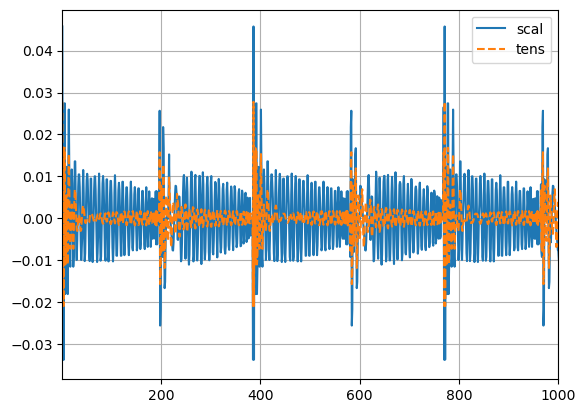

PyObject <matplotlib.legend.Legend object at 0x2831aef20>

In [14]:
using PyPlot

len = 1:1:147456

PyPlot.plot(len, cov_mat_scal[:], label = "scal")
PyPlot.plot(len, cov_mat_tens[:], label = "tens", linestyle = "dashed")
PyPlot.grid()
PyPlot.xlim(1, 1000)
PyPlot.legend()

In [15]:
prod(size(cov_mat))

147456

In [16]:
#using Plots 

#heatmap(cov_mat)

In [17]:
cov_mat - cov_mat_py;

In [18]:
all(cov_mat - cov_mat_py .≤ 1e-6)

true

In [19]:
noise_seed = [1, 2, 3]
pol_sen = 0.2 # μK
nside = 4

art_noise_cov_mat =  calc_noise_cov_mat(pol_sen, nside, noise_seed);
art_noise_map, sigma = calc_noise_map(pol_sen, nside, noise_seed);

### logdetの計算

In [20]:
log_det(cov_mat + art_noise_cov_mat)

-4640.168000454326

In [21]:
cholesky_logdet(cov_mat + art_noise_cov_mat)

-4640.168000461168

In [22]:
log_det(cov_mat_py + art_noise_cov_mat)

-4640.1677085847405

In [23]:
log(det(cov_mat + art_noise_cov_mat))

-Inf

In [24]:
noise_map = [art_noise_map[1]; art_noise_map[2]];

### clean_mapの確認

In [25]:
#==
using PyCall

npix = nside2npix(nside)

plt = pyimport("matplotlib.pyplot")
hp = pyimport("healpy")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(x[1:npix], title="clean_map_Q", hold=true)

plt.axes(ax2)
hp.mollview(x[npix + 1:2 * npix], title="clean_map_U", hold=true)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(cmb_data[2, :], title="Imput_map_Q", hold=true)

plt.axes(ax2)
hp.mollview(cmb_data[3, :], title="Imput_map_U", hold=true)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(smoothing_cmb_map[2, :], title="Imput_map_Q", hold=true)

plt.axes(ax2)
hp.mollview(smoothing_cmb_map[3, :], title="Imput_map_U", hold=true)
==#

In [26]:
cov_mat_py1 = npzread("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/python_cov_mat/cov_mat_py.npy")
xx_py = npzread("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/python_cov_mat/xx_py.npy");

In [27]:
#x_map' / cov_mat * x_map

In [28]:
#xx_py' / cov_mat_py1 * xx_py

In [29]:
#x_map' / cov_mat_py1 * x_map

In [30]:
#xx - xx_py;

In [31]:
# lmaxの違いだった
#==

using PyPlot
hp = pyimport("healpy")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(xx[1:192, 1], title="julia_Q", hold=true)

plt.axes(ax2)
hp.mollview(xx[193:384, 1], title="julia_U", hold=true)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(xx_py[1:192, 1], title="python_Q", hold=true)

plt.axes(ax2)
hp.mollview(xx_py[193:384, 1], title="python_U", hold=true)

==#

In [32]:
# いい精度であってる
#cov_mat - cov_mat_py1

### likelihood for ループ

In [63]:
r_in = 0:1e-4:1
like_array = zeros(length(r_in))
i = 1
#setprecision(BigFloat, 100) 

Q, U, x_map = calc_x_pra(freq_band, 140, nside, cmb_data, "s1", freq_bs, -3., freq_bd, beta_d, T_d);

@inbounds @time for r_pre in r_in
    
    cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, r_pre) + art_noise_cov_mat

    x_with_noise = x_map + noise_map

    #det_C = log_det(cov_mat)

    # コレスキー ver
    det_C = cholesky_logdet(cov_mat)

    like_array[i] = x_with_noise' / cov_mat * x_with_noise + det_C

    i += 1
    
    #push!(like_array, x_with_noise' / cov_mat * x_with_noise + det_C)

    #================python======================#
    #cov_mat_py = calc_all_cov_mat(cov_mat_scal_py, cov_mat_tens_py, r_pre) + art_noise_cov_mat
    #det_C = cholesky_logdet(cov_mat_py)
    #push!(like_array, x_with_noise' / cov_mat_py * x_with_noise  + det_C)
    
    # big float
    #push!(like_array, big.(x_map)' / big.(cov_mat) * big.(x_map) + big.(det_C))

end

 25.504597 seconds (269.01 k allocations: 66.078 GiB, 9.62% gc time)


In [64]:
like_array = (like_array ./ maximum(like_array));

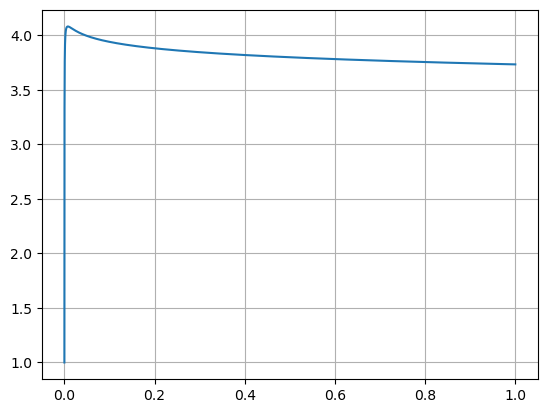

In [65]:
using PyPlot
PyPlot.plot(r_in, like_array)
PyPlot.grid()

In [66]:
#r_in[argmin(like_array)]

r_in[argmax(like_array)]

0.0078

### χ^2のループ

In [71]:
chi_sq_array = []

beta_in = -4:1e-3:-2

cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, 0.01) + art_noise_cov_mat

#setprecision(BigFloat, 100) 

@time for beta_pre in beta_in

    Q, U, x_map = calc_x_pra(freq_band, 140, nside, cmb_data, "s1", freq_bs, beta_pre, freq_bd, beta_d, T_d)
    
    x = x_map + noise_map

    push!(chi_sq_array, x_map' / cov_mat * x_map)

    #push!(like_array, big.(x_map)' / big.(cov_mat) * big.(x_map) + big.(det_C))
end

  3.414840 seconds (821.91 k allocations: 2.458 GiB, 3.37% gc time)


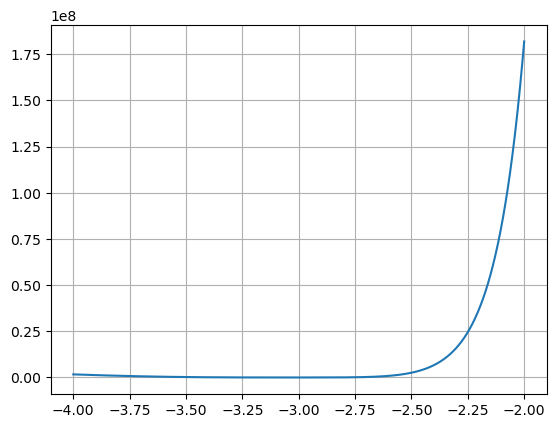

In [72]:
fig = ()
PyPlot.plot(beta_in, chi_sq_array)
PyPlot.grid()

In [73]:
chi_sq_array
beta_in[argmin(chi_sq_array)]

-3.009

### Optimによるパラメータ推定

In [40]:
r = 0.001

function minimize_function_chi_sq(param)
    
    #beta_s, r = param[1], param[2]
    beta_s = param
    
    cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, r) + art_noise_cov_mat

    Q_1, U_1, x_map = calc_x_pra(freq_band, 140, nside, cmb_data, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)

    x_with_noise = x_map + noise_map
    
    return x_map' / cov_mat * x_map

end

minimize_function_chi_sq (generic function with 1 method)

In [41]:
beta_s = -3.

function minimize_function_like(param)

    #beta_s, r = param[1], param[2]
    r = param
    
    cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, r) + art_noise_cov_mat

    Q_1, U_1, x_map = calc_x_pra(freq_band, 140, nside, cmb_data, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)

    x_with_noise = x_map + noise_map
    
    det_C = cholesky_logdet(cov_mat)
    
    return x_with_noise' / cov_mat * x_with_noise + det_C

end

minimize_function_like (generic function with 1 method)

In [42]:
using Optim

result = optimize(minimize_function_chi_sq, -4.0, -2.0) #-2から1の間の最小値を探す。

optimal_values = Optim.minimizer(result)
minimized_value = Optim.minimum(result)

# 結果の表示
println(result)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-4.000000, -2.000000]
 * Minimizer: -3.008673e+00
 * Minimum: 1.313316e+03
 * Iterations: 14
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 15


In [43]:
optimal_values

-3.0086732017463063

In [44]:
using Optim

result = optimize(minimize_function_like, 0., 1) #-2から1の間の最小値を探す。

optimal_values = Optim.minimizer(result)
minimized_value = Optim.minimum(result)

# 結果の表示
println(result)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 7.772911e-03
 * Minimum: -3.481156e+03
 * Iterations: 32
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 33


In [45]:
optimal_values
#minimized_value

0.007772911378975566

### 最小化のアルゴリズム

In [87]:
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/param_estimate.jl")


minimize_function_like (generic function with 1 method)

In [88]:
#pram_estimate(r, freq_band, 140, nside, cmb_data, which_model, freq_bs, beta_s, freq_bd, beta_d, T_d, cov_mat_scal, cov_mat_tens)



In [77]:
function minimize_function_chi_sq(beta_s, r)
    
    cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, r) + art_noise_cov_mat

    Q_1, U_1, x_map = calc_x_pra(freq_band, 140, nside, cmb_data, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)

    x_with_noise = x_map + noise_map
    
    return x_with_noise' / cov_mat * x_with_noise

end

minimize_function_chi_sq (generic function with 2 methods)

In [83]:
function minimize_function_like(r, beta_s)

    cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, r) + art_noise_cov_mat

    Q_1, U_1, x_map = calc_x_pra(freq_band, 140, nside, cmb_data, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)

    x_with_noise = x_map + noise_map
    
    det_C = cholesky_logdet(cov_mat)
    
    return x_with_noise' / cov_mat * x_with_noise + det_C

end

minimize_function_like (generic function with 2 methods)

In [79]:
using Optim

# 固定するrの値と初期のbeta_sの値を設定します
fixed_r = 0.001
initial_beta_s = -3 # 初期値は範囲の中心に設定

# 最適化のための関数を定義
objective_function(beta_s) = minimize_function_chi_sq(beta_s, fixed_r)

# 最適化オプションを設定（Brent法を使用）
opt = optimize(objective_function, -4.0, -2.0, Brent())

# 結果を取得
optimum_beta_s = Optim.minimizer(opt)
optimum_value = Optim.minimum(opt)

println("Optimum beta_s: ", optimum_beta_s)
println("Minimum value: ", optimum_value)

Optimum beta_s: -3.0091196655785786
Minimum value: 1493.7447685376465


In [85]:
using Optim

initial_r = 0.001
fixed_beta_s = -3

# 最適化のための関数を定義
objective_function(r) = minimize_function_like(r, fixed_beta_s)

# 最適化オプションを設定（Brent法を使用）
opt = optimize(objective_function, 0., 1., Brent())

# 結果を取得
optimum_r = Optim.minimizer(opt)
optimum_value = Optim.minimum(opt)

println("Optimum beta_s: ", optimum_r)
println("Minimum value: ", optimum_value)

Optimum beta_s: 0.007772911378975566
Minimum value: -3481.156481142707
